### Imports

In [35]:
# OS I/O
import os
import pickle

# Data handling
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV #, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay #, classification_report# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns




## Preprocessing (from Bart)

In [3]:
path_features_train = "../raw_data/tox21_dense_train.csv.gz"
X_raw = pd.read_csv(path_features_train).set_index("Unnamed: 0")

In [4]:
# Column Transformer with MinMax-Scaler
column_transformer = ColumnTransformer([
    ("scaler", MinMaxScaler(), X_raw.columns)
    ])

# Pipeline
pipeline = Pipeline([
    ("transform", column_transformer)
    ])

# Transform data while preserving column names
X = pd.DataFrame(pipeline.fit_transform(X_raw), columns=X_raw.columns, index=X_raw.index)


In [5]:
path_targets_train = "../raw_data/tox21_labels_train.csv.gz"
y = pd.read_csv(path_targets_train).set_index("Unnamed: 0")

In [6]:
y_mmp = y[["SR.MMP"]].dropna()

In [7]:
mmp_train = y_mmp.merge(X, how="inner", on="Unnamed: 0")

In [21]:
mmp_train.head()

,SR.MMP,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NCGC00165865-01,1.0,6.341000e-08,0.017366,0.812523,0.789928,0.273763,0.270577,0.119708,0.282093,0.256368,...,0.041851,0.032067,0.195228,0.987276,0.964649,0.085498,0.016266,0.032846,0.000227,0.323018
NCGC00095025-01,1.0,4.232804e-01,0.009179,0.776528,0.677698,0.213232,0.215202,0.053085,0.195447,0.160676,...,0.019685,0.032279,0.042972,0.996306,0.977962,0.097667,0.024509,0.038591,0.000160,0.233044
NCGC00255209-01,1.0,8.695657e-02,0.012498,0.717285,0.649496,0.169998,0.168857,0.022973,0.148787,0.113646,...,0.014453,0.029822,0.053196,0.996467,0.968684,0.099991,0.019386,0.035609,0.000114,0.264252
NCGC00260005-01,1.0,3.760000e-08,0.005746,0.809899,0.755683,0.190918,0.187776,0.047752,0.192760,0.187370,...,0.014743,0.018509,0.058717,0.996961,0.985609,0.081238,0.012272,0.031258,0.000129,0.220536
NCGC00258363-01,1.0,5.882360e-02,0.022841,0.705662,0.636547,0.256603,0.257801,0.048654,0.195549,0.162270,...,0.046014,0.117323,0.077582,0.991233,0.939187,0.269463,0.088882,0.090879,0.000196,0.371946


## Our Baseline Model : Random Forest (From Ivan)

In [8]:
X_mmp_train = mmp_train.drop(columns=["SR.MMP"])
print(X_mmp_train.shape)
y_mmp_train = mmp_train["SR.MMP"]
print(y_mmp_train.shape)

(7558, 801)
(7558,)


In [40]:
y_mmp_train.head()

Unnamed: 0
NCGC00165865-01    1.0
NCGC00095025-01    1.0
NCGC00255209-01    1.0
NCGC00260005-01    1.0
NCGC00258363-01    1.0
Name: SR.MMP, dtype: float64

In [10]:
# Model Instantiation and Fit
rf_mmp = RandomForestClassifier()
rf_mmp.fit(X_mmp_train, y_mmp_train)

RandomForestClassifier()

In [11]:
rf_mmp_cv = cross_validate(rf_mmp, X=X_mmp_train, y=y_mmp_train, cv=5,
                                scoring=["accuracy",
                                         "recall",
                                         "precision",
                                         "f1"
                                        ]
                               )


In [16]:
rf_mmp_scoring_metrics = pd.DataFrame((list(rf_mmp_cv.values()))[2:]).mean(axis=1)
keys = ["accuracy", "recall", "precision", "f1"]
logit_scoring_metrics = dict(zip(keys, list(rf_mmp_scoring_metrics)))
logit_scoring_metrics

{'accuracy': 0.8881990622559781,
 'recall': 0.4093220338983051,
 'precision': 0.7802292866417043,
 'f1': 0.5318529097288185}

# Predictions, Classification Reports and Confusion Matrices

### Importing and preparing test dataset for MMP

In [32]:
path_features_test = "../raw_data/tox21_dense_test.csv.gz" 
X_test = pd.read_csv(path_features_test).set_index("Unnamed: 0")
X_test

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NCGC00261900-01,2.612482e+07,12.688,2.226,3.226,37.329,25.440,3.663,24.200,20.222,4.565,...,9687.312,42351.907,194.444,-2518.829,-83.110,772.051,10001.075,131.633,145.967,5.499
NCGC00260869-01,8.333337e+06,17.500,2.167,2.923,16.353,10.872,1.193,11.116,9.279,2.693,...,1256.410,2621.885,104.011,-475.829,-33.456,219.411,1003.763,76.703,76.043,3.728
NCGC00261776-01,4.074000e+00,12.464,2.364,3.043,14.681,10.826,2.149,9.980,9.469,1.342,...,1072.430,3152.648,93.486,-341.628,-21.327,174.791,638.757,32.885,45.933,3.657
NCGC00261380-01,8.000005e+06,13.827,2.080,2.845,16.778,11.720,0.777,10.139,8.207,1.251,...,1408.177,4596.402,127.215,-519.799,-27.729,199.061,813.323,35.712,58.214,3.659
NCGC00261842-01,4.838000e+00,14.509,2.087,2.880,16.872,10.920,0.413,10.035,7.719,2.090,...,1217.075,4343.460,134.802,-816.522,-55.496,192.858,1168.142,33.190,57.065,3.635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCGC00357168-01,2.000000e+00,16.820,1.600,1.157,4.121,2.414,0.000,1.354,0.707,0.000,...,25.161,207.065,25.378,-34.751,-8.135,45.801,62.715,7.705,6.893,1.868
NCGC00357283-01,3.714000e+00,13.208,2.000,2.134,11.096,7.296,0.072,5.671,4.091,0.612,...,406.748,2632.001,51.600,-186.503,-25.487,151.500,547.566,24.878,29.311,2.976
NCGC00357210-01,1.905000e+00,16.017,2.000,2.295,5.276,3.305,0.000,2.885,2.290,0.471,...,49.621,146.562,34.623,-39.767,-6.189,38.729,44.481,7.121,12.809,1.779


In [43]:
path_targets_test = "../raw_data/tox21_labels_test.csv.gz" 
y_test = pd.read_csv(path_targets_test).set_index("Unnamed: 0")
y_test

,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
Unnamed: 0,,,,,,,,,,,,
NCGC00261900-01,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
NCGC00260869-01,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCGC00261776-01,1.0,1.0,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
NCGC00261380-01,NaN,0.0,NaN,1.0,0.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN
NCGC00261842-01,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
NCGC00357168-01,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
NCGC00357283-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCGC00357210-01,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0


In [44]:
y_test_mmp = y_test[["SR.MMP"]].dropna()
y_test_mmp

,SR.MMP
Unnamed: 0,
NCGC00260869-01,0.0
NCGC00261776-01,1.0
NCGC00261380-01,0.0
NCGC00261190-01,1.0
NCGC00260731-01,1.0
...,...
NCGC00356954-01,0.0
NCGC00357020-01,0.0
NCGC00357168-01,0.0


In [45]:
mmp_test = y_test_mmp.merge(X_test, how="inner", on="Unnamed: 0")

In [46]:
mmp_test.head()

,SR.MMP,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NCGC00260869-01,0.0,8333337.272,17.500,2.167,2.923,16.353,10.872,1.193,11.116,9.279,...,1256.410,2621.885,104.011,-475.829,-33.456,219.411,1003.763,76.703,76.043,3.728
NCGC00261776-01,1.0,4.074,12.464,2.364,3.043,14.681,10.826,2.149,9.980,9.469,...,1072.430,3152.648,93.486,-341.628,-21.327,174.791,638.757,32.885,45.933,3.657
NCGC00261380-01,0.0,8000004.927,13.827,2.080,2.845,16.778,11.720,0.777,10.139,8.207,...,1408.177,4596.402,127.215,-519.799,-27.729,199.061,813.323,35.712,58.214,3.659
NCGC00261190-01,1.0,4.234,14.747,2.211,2.799,13.621,8.927,0.722,9.321,6.798,...,791.769,1283.646,128.674,-406.842,-35.550,86.222,272.626,19.470,44.100,3.671
NCGC00260731-01,1.0,3.958,14.892,2.125,2.665,11.544,7.686,0.326,6.845,5.464,...,524.169,1676.800,79.009,-227.586,-21.547,147.834,425.881,26.126,33.066,3.659


### Making predictions

In [48]:
X_test_mmp = mmp_test.drop(columns=["SR.MMP"])
X_test_mmp.head()

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NCGC00260869-01,8333337.272,17.500,2.167,2.923,16.353,10.872,1.193,11.116,9.279,2.693,...,1256.410,2621.885,104.011,-475.829,-33.456,219.411,1003.763,76.703,76.043,3.728
NCGC00261776-01,4.074,12.464,2.364,3.043,14.681,10.826,2.149,9.980,9.469,1.342,...,1072.430,3152.648,93.486,-341.628,-21.327,174.791,638.757,32.885,45.933,3.657
NCGC00261380-01,8000004.927,13.827,2.080,2.845,16.778,11.720,0.777,10.139,8.207,1.251,...,1408.177,4596.402,127.215,-519.799,-27.729,199.061,813.323,35.712,58.214,3.659
NCGC00261190-01,4.234,14.747,2.211,2.799,13.621,8.927,0.722,9.321,6.798,2.436,...,791.769,1283.646,128.674,-406.842,-35.550,86.222,272.626,19.470,44.100,3.671
NCGC00260731-01,3.958,14.892,2.125,2.665,11.544,7.686,0.326,6.845,5.464,1.099,...,524.169,1676.800,79.009,-227.586,-21.547,147.834,425.881,26.126,33.066,3.659


In [59]:
y_test_mmp = mmp_test['SR.MMP']

In [60]:
y_pred_mmp = rf_mmp.predict(X_test_mmp)

In [61]:
print(len(X_test_mmp), len(y_test_mmp))

543 543


In [62]:
len(y_pred)

543

In [64]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test_mmp, y_pred_mmp, target_names=["Non-toxic", "Toxic"]))

Classification Report:

              precision    recall  f1-score   support

   Non-toxic       0.91      0.76      0.83       483
       Toxic       0.18      0.42      0.25        60

    accuracy                           0.72       543
   macro avg       0.54      0.59      0.54       543
weighted avg       0.83      0.72      0.76       543



Printing the confusion matrix focusing on the F1 score: balance of precision and recall


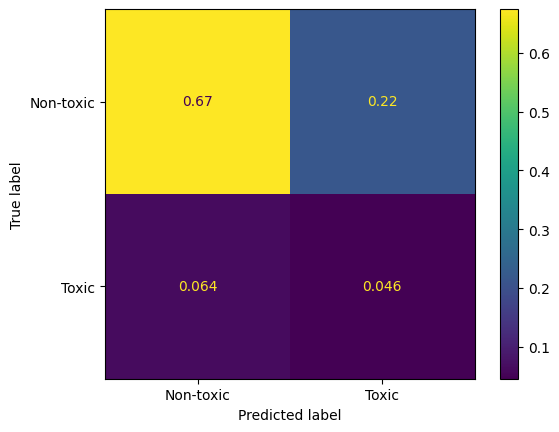

In [71]:
print("Printing the confusion matrix focusing on the F1 score: balance of precision and recall")
cm = confusion_matrix(y_test_mmp, y_pred_mmp,
                     normalize = 'all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-toxic", "Toxic"])
disp.plot()